In [5]:
"""
Segmentação de Clientes RFM - Base Olist
Autor: Evelin Lins
Objetivo: Processar dados de e-commerce e classificar clientes por comportamento de compra.
"""

# A seleção deste stack tecnológico visa a escalabilidade da análise
# e a precisão no processamento de grandes volumes de dados (Big Data).
# O foco é a transformação de dados brutos em ativos de decisão de marketing
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Configurações visuais para que os insights sejam legíveis e profissionais
%matplotlib inline
sns.set(style="whitegrid")

print("Framework estratégico inicializado com sucesso. 🚀")

Framework estratégico inicializado com sucesso. 🚀


In [6]:
# O carregamento das bases transacionais e cadastrais é o primeiro passo
# do processo de ETL (Extract, Transform, Load), essencial para criar
# uma fundação de dados confiável para a segmentação RFM.

df_orders = pd.read_csv('olist_orders_dataset.csv')
df_payments = pd.read_csv('olist_order_payments_dataset.csv')
df_customers = pd.read_csv('olist_customers_dataset.csv')

# Exibindo as dimensões (linhas, colunas) para auditoria rápida
print(f"Ordens: {df_orders.shape}")
print(f"Pagamentos: {df_payments.shape}")
print(f"Clientes: {df_customers.shape}")

Ordens: (99441, 8)
Pagamentos: (103886, 5)
Clientes: (99441, 5)


In [9]:
# A consolidação das bases visa criar a Single Customer View.
# Filtramos apenas as features necessárias para o modelo RFM, otimizando
# o uso de memória e focando na integridade dos KPIs de transação.

# 1. Cruzando Pedidos com Pagamentos
df_com_valor = pd.merge(df_orders, df_payments, on='order_id')

# 2. Cruzando com a tabela de Clientes para ter o ID Único
df_completo = pd.merge(df_com_valor, df_customers, on='customer_id')

# 3. Selecionando apenas as 3 colunas que o RFM exige:
# customer_unique_id (F), order_purchase_timestamp (R), payment_value (M)
df_rfm = df_completo[['customer_unique_id', 'order_purchase_timestamp', 'payment_value']]

# 4. Renomeando para nomes profissionais e fáceis de ler
df_rfm.columns = ['ID_Cliente', 'Data_Compra', 'Valor']

# Visualizando se o "Tabelão" ficou pronto
print("Sucesso! Veja as primeiras linhas do seu 'Tabelão' de RFM:")
display(df_rfm.head())

,ID_Cliente,Data_Compra,Valor
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,18.12
1,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,2.00
2,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,18.59
3,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,141.46
4,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,179.12


In [12]:
# A sanitização de tipos (casting para datetime64) é etapa obrigatória
# antes de operações de delta temporal para evitar exceções de tipo.

# --- PARTE 0: Forçar a conversão para Data (O pulo do gato!) ---
df_rfm['Data_Compra'] = pd.to_datetime(df_rfm['Data_Compra'])

# --- PARTE 1: Definindo a data de referência ---
data_hoje = df_rfm['Data_Compra'].max() + pd.Timedelta(days=1)

# --- PARTE 2: Agrupando para criar o RFM ---
rfm = df_rfm.groupby('ID_Cliente').agg({
    'Data_Compra': lambda x: (data_hoje - x.max()).days, # Recência
    'ID_Cliente': 'count',                             # Frequência
    'Valor': 'sum'                                      # Monetário
})

# Renomeando as colunas
rfm.columns = ['Recencia', 'Frequencia', 'Monetario']
df_rfm = df_completo[['customer_unique_id', 'order_purchase_timestamp', 'payment_value']].copy()
print("Tabela RFM gerada com sucesso! 🚀")
rfm.head()

,Recencia,Frequencia,Monetario
ID_Cliente,,,
0000366f3b9a7992bf8c76cfdf3221e2,161,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,164,1,27.19
0000f46a3911fa3c0805444483337064,586,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,370,1,43.62
0004aac84e0df4da2b147fca70cf8255,337,1,196.89


In [13]:
# A utilização de quintis (qcut) permite uma segmentação relativa,
# comparando o desempenho dos clientes entre si. Isso elimina a
# necessidade de definir limites arbitrários e foca na curva real da base.

# 1. Criando as notas (Scores)
# Para Recência, as notas são invertidas (labels=[5, 4, 3, 2, 1])
rfm['R'] = pd.qcut(rfm['Recencia'], 5, labels=[5, 4, 3, 2, 1])

# Para Frequência, usamos o método 'rank' porque muitos clientes compram apenas 1 vez
rfm['F'] = rfm['Frequencia'].rank(method='first')
rfm['F'] = pd.qcut(rfm['F'], 5, labels=[1, 2, 3, 4, 5])

# Para Monetário
rfm['M'] = pd.qcut(rfm['Monetario'], 5, labels=[1, 2, 3, 4, 5])

# 2. Criando o RFM_Score final (uma nota única de 3 dígitos, ex: 555)
rfm['RFM_Score'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)

print("Segmentação concluída! Veja as notas dos seus clientes:")
display(rfm.head())

,Recencia,Frequencia,Monetario,R,F,M,RFM_Score
ID_Cliente,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,161,1,141.90,4,1,4,414
0000b849f77a49e4a4ce2b2a4ca5be3f,164,1,27.19,4,1,1,411
0000f46a3911fa3c0805444483337064,586,1,86.22,1,1,2,112
0000f6ccb0745a6a4b88665a16c9f078,370,1,43.62,2,1,1,211
0004aac84e0df4da2b147fca70cf8255,337,1,196.89,2,1,4,214


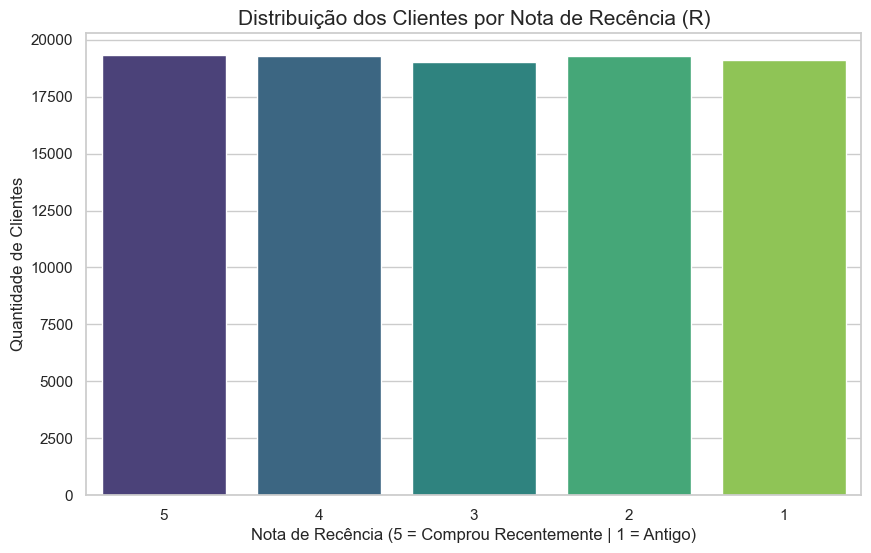

In [14]:
# A distribuição de frequência dos scores de Recência revela o 'health score'
# da base ativa. Um skew (inclinação) para a esquerda (notas 1 e 2) indica
# a necessidade urgente de campanhas de reativação (win-back).

plt.figure(figsize=(10, 6))
sns.countplot(data=rfm, x='R', palette='viridis')

plt.title('Distribuição dos Clientes por Nota de Recência (R)', fontsize=15)
plt.xlabel('Nota de Recência (5 = Comprou Recentemente | 1 = Antigo)', fontsize=12)
plt.ylabel('Quantidade de Clientes', fontsize=12)
plt.show()

In [15]:
# A clusterização por Regex permite agrupar personas acionáveis.
# Isso permite que o time de CRM crie réguas de comunicação distintas
# para cada nível de maturidade do cliente na base.

segmentos_map = {
    r'[1-2][1-2]': 'Perdidos',
    r'[1-2][3-4]': 'Em Risco',
    r'[1-2]5': 'Não posso perder',
    r'3[1-2]': 'Prestes a dormir',
    r'33': 'Precisa de atenção',
    r'[3-4][4-5]': 'Clientes Fiéis',
    r'41': 'Promissores',
    r'51': 'Novos clientes',
    r'[4-5][2-3]': 'Potencialmente fiéis',
    r'5[4-5]': 'Campeões'
}

rfm['Segmento'] = rfm['R'].astype(str) + rfm['F'].astype(str)
rfm['Segmento'] = rfm['Segmento'].replace(segmentos_map, regex=True)

print("Status: Clientes rotulados com sucesso! 🏷️")
rfm.head()

,Recencia,Frequencia,Monetario,R,F,M,RFM_Score,Segmento
ID_Cliente,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,161,1,141.90,4,1,4,414,Promissores
0000b849f77a49e4a4ce2b2a4ca5be3f,164,1,27.19,4,1,1,411,Promissores
0000f46a3911fa3c0805444483337064,586,1,86.22,1,1,2,112,Perdidos
0000f6ccb0745a6a4b88665a16c9f078,370,1,43.62,2,1,1,211,Perdidos
0004aac84e0df4da2b147fca70cf8255,337,1,196.89,2,1,4,214,Perdidos


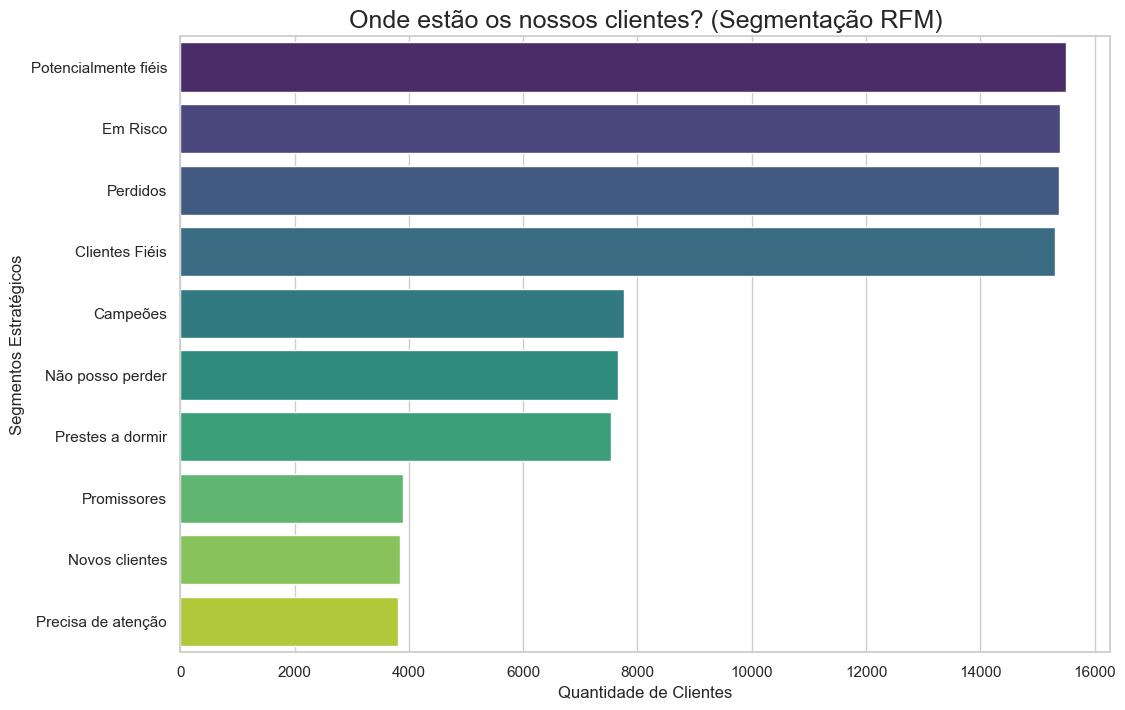

In [18]:
# Vamos desenhar o ranking de qual grupo de clientes é maior.

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Definir o tamanho da figura
plt.figure(figsize=(12, 8))

# 2. Criar o gráfico de barras (contagem de cada segmento)
# O 'y' faz as barras ficarem deitadas, o que facilita muito a leitura dos nomes
ordem = rfm['Segmento'].value_counts().index
sns.countplot(data=rfm, y='Segmento', order=ordem, palette='viridis')

# 3. Colocar os títulos estratégicos
plt.title("Onde estão os nossos clientes? (Segmentação RFM)", fontsize=18)
plt.xlabel("Quantidade de Clientes", fontsize=12)
plt.ylabel("Segmentos Estratégicos", fontsize=12)

# 4. O comando que faz a mágica aparecer
plt.show()

In [25]:
# criando arquivo no excel: Resultado_Final_RFM_Evelin

rfm.to_excel("Resultado_Final_RFM_Evelin.xlsx")

print("✅ ARQUIVO GERADO COM SUCESSO!")
print("Procure por 'Resultado_Final_RFM_Evelin.xlsx' na sua pasta.")

✅ ARQUIVO GERADO COM SUCESSO!
Procure por 'Resultado_Final_RFM_Evelin.xlsx' na sua pasta.


In [26]:
# A análise descritiva dos segmentos valida a coerência do modelo RFM.
# KPIs de saída: Ticket Médio por cluster e frequência média.

print("\n--- RESUMO ESTRATÉGICO DA BASE DE CLIENTES ---")
resumo = rfm.groupby('Segmento').agg({
    'Recencia': 'mean',
    'Frequencia': 'mean',
    'Monetario': ['mean', 'count']
}).round(2)

# Ordenando pelos clientes que gastam mais (Ticket Médio)
resumo = resumo.sort_values(by=('Monetario', 'mean'), ascending=False)

display(resumo)

print("\n✅ PROJETO FINALIZADO: Dados processados, segmentados e exportados.")
print("Analista responsável: Evelin")


✅ PROJETO FINALIZADO: Dados processados, segmentados e exportados.
Analista responsável: Evelin


In [27]:
# Business Intelligence Prescritiva. Transformamos clusters em
# Planos de Ação (Action Plans) com foco em ROI e Retenção.

print("\n" + "="*50)
print("ESTRATÉGIA DE NEGÓCIO - RECOMENDAÇÕES RFM")
print("="*50)

# Calculando métricas para o Storytelling
total_clientes = len(rfm)
campeoes = len(rfm[rfm['Segmento'] == 'Campeões'])
em_risco = len(rfm[rfm['Segmento'] == 'Em Risco'])
perdidos = len(rfm[rfm['Segmento'] == 'Perdidos'])

print(f"📊 DIAGNÓSTICO DA BASE:")
print(f"- Dos {total_clientes} clientes, {campeoes} são CAMPEÕES (Pilar de Receita).")
print(f"- Temos {em_risco} clientes EM RISCO (Perda iminente de faturamento).")
print(f"- {perdidos} clientes já são considerados PERDIDOS.")

print("\n🚀 PLANO DE AÇÃO RECOMENDADO:")

print("\n1. PARA OS CAMPEÕES:")
print("   -> Ação: Programa de Fidelidade e Mimos. Não use descontos agressivos.")
print("   -> Objetivo: Transformá-los em defensores da marca (Advocacy).")

print("\n2. PARA OS EM RISCO / PRESTES A DORMIR:")
print("   -> Ação: Campanhas de Reativação Urgentes (Win-back).")
print("   -> Objetivo: Evitar que migrem para o grupo de Perdidos.")

print("\n3. PARA OS NOVOS CLIENTES:")
print("   -> Ação: Régua de Boas-vindas e oferta para a 2ª compra.")
print("   -> Objetivo: Aumentar o LTV (Lifetime Value) desde cedo.")

print("\n" + "="*50)
print("Relatório gerado por: Evelin - Analista de Dados Estratégica")
print("="*50)

📊 DIAGNÓSTICO DA BASE:
- Dos 96095 clientes, 7764 são CAMPEÕES (Pilar de Receita).
- Temos 15390 clientes EM RISCO (Perda iminente de faturamento).
- 15385 clientes já são considerados PERDIDOS.

🚀 PLANO DE AÇÃO RECOMENDADO:

1. PARA OS CAMPEÕES:
   -> Ação: Programa de Fidelidade e Mimos. Não use descontos agressivos.
   -> Objetivo: Transformá-los em defensores da marca (Advocacy).

2. PARA OS EM RISCO / PRESTES A DORMIR:
   -> Ação: Campanhas de Reativação Urgentes (Win-back).
   -> Objetivo: Evitar que migrem para o grupo de Perdidos.

3. PARA OS NOVOS CLIENTES:
   -> Ação: Régua de Boas-vindas e oferta para a 2ª compra.
   -> Objetivo: Aumentar o LTV (Lifetime Value) desde cedo.

Relatório gerado por: Evelin - Analista de Dados Estratégica
